# Titanic: to survive or not to survive

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import cross_validation as cva
from sklearn.ensemble import RandomForestClassifier as rfc
#from sklearn.cross_validation import KFold

titanic = pd.read_csv('train.csv')
original_data = titanic.copy()
titanic.shape

(891, 12)

In [2]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.describe()

C:\Users\rmh63\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Feature: Age ###

14.526497332334044


C:\Users\rmh63\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


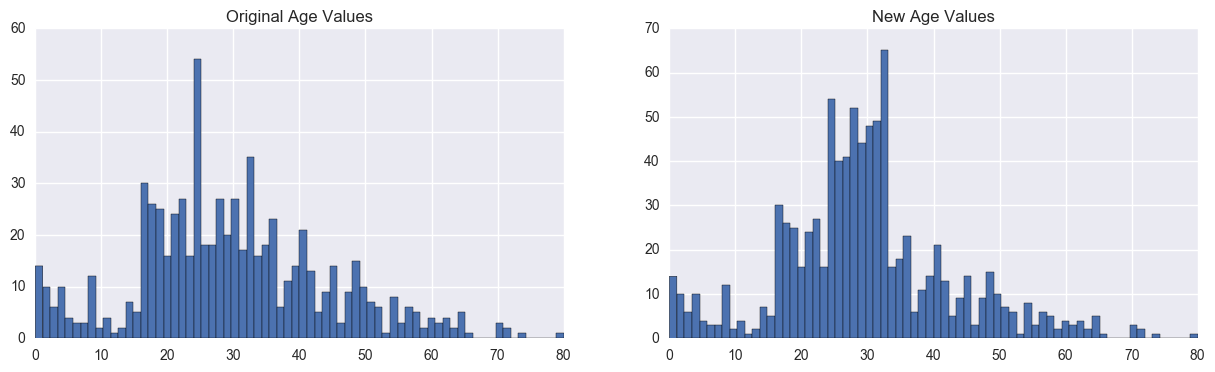

In [4]:
##AGE##
#Let's explore and work with Age a bit. Since there seems to be 177 missing values, the first question is what to fill them with.
#Option1: fill with median
#Option2: fill with random values between +-1 standard deviation from the mean. (From Omar El Gabry)
    #While I think this is an interesting approach, I am seeing that the random values set for ages affects the ML output
    #by about 2%. After running a few times, I've seen 78%-80%. TO BE FURTHER INVESTIGATED.
    
    #Current std = 13 years, which means this technique yields random ages between 16 and 42. That seems way
    #too big, considering how low survival rate is around 20yrs old.

#---------------------------------------#
##Option1:
##Fill the NaN values in Age with the median of Age
#titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
#sns.distplot(titanic['Age'])
#---------------------------------------#

#Option2:
#Get some statistics
age_mean = titanic['Age'].mean()
age_std = titanic['Age'].std()
print(age_std)
age_nan_count = titanic['Age'].isnull().sum()

#Generate random numbers between +-1 std and mean
age_rand = np.random.randint(age_mean-age_std/4, age_mean+age_std/4, size=age_nan_count)

#Setting up plots 
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age Values')
axis2.set_title('New Age Values')

#Plot original Age values
titanic['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

#Plot new Age values
titanic['Age'][np.isnan(titanic["Age"])] = age_rand
titanic['Age'].astype(int).hist(bins=70, ax=axis2)


#sns.distplot(titanic_orig['Age'], ax=axis1)
#sns.distplot(titanic_new['Age'], ax=axis2)



C:\Users\rmh63\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


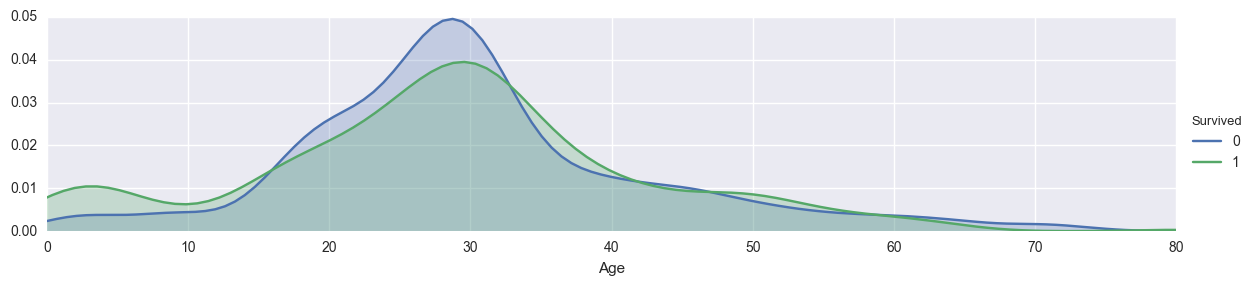

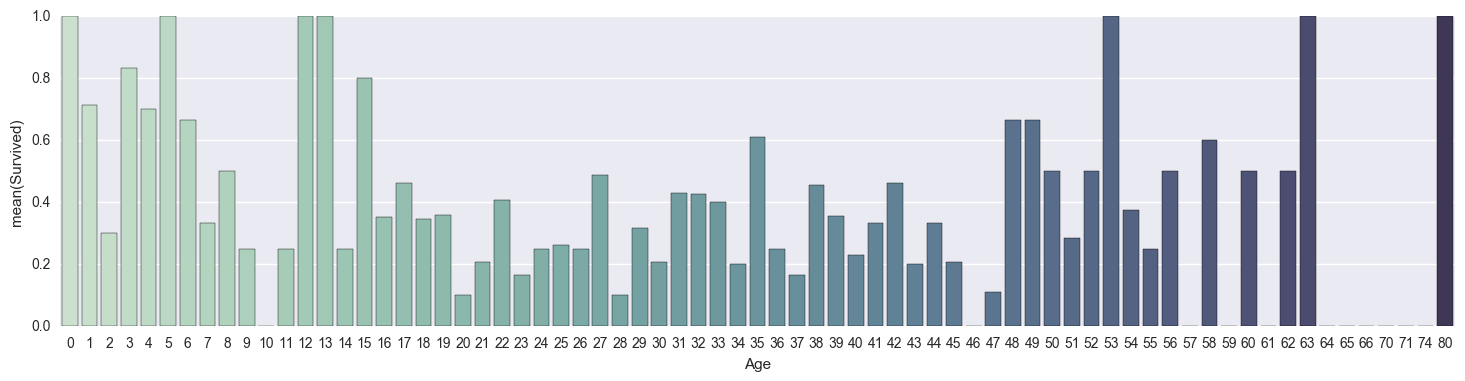

In [5]:
##AGE cont##
#Let's take a look at how survival rates are distributed over age

#Let's plot a distribution of survival over age
g = sns.FacetGrid(titanic, hue='Survived', aspect=4)
g.map(sns.kdeplot, "Age", shade=True)
sns.despine(left=True, bottom=False)
g.set(xlim=(0, 80))
g.add_legend()
plt.show()

#Let's plot average survival per age
fig, ax1 = plt.subplots(1,1,figsize=(18,4))
avg_survival = titanic[['Age','Survived']].groupby('Age',as_index=False).mean()
avg_survival['Age'] = avg_survival['Age'].astype(int) 

color = sns.cubehelix_palette(80, start=.5, rot=-.6)
sns.barplot(x='Age', y='Survived', data=avg_survival, palette=color, ci=None)


### Feature: Sex ###

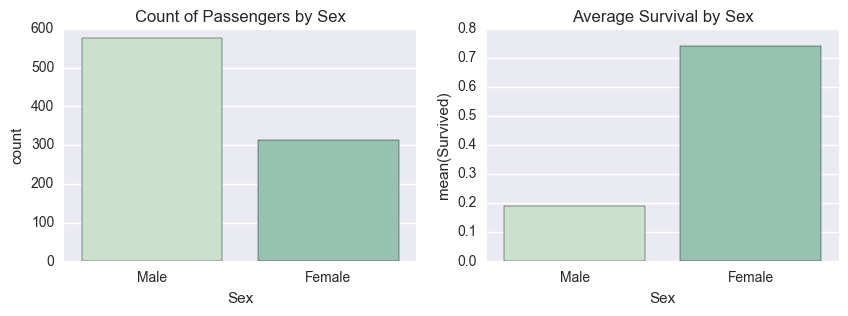

In [6]:
#Convert the Sex column to 0:Male, 1:Female
titanic.loc[titanic['Sex']=='male','Sex'] = 0
titanic.loc[titanic['Sex']=='female','Sex'] = 1
titanic['Sex'].value_counts()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3))
ax1.set_title('Count of Passengers by Sex')
ax2.set_title('Average Survival by Sex')

color = sns.cubehelix_palette(6, start=.5, rot=-.6)

avg_surv = titanic[['Sex','Survived']].groupby('Sex', as_index=False).mean()

sns.countplot(data=titanic, x='Sex', ax=ax1, palette=color)
sns.barplot(data=avg_surv, x='Sex', y='Survived', ax=ax2, palette=color)
ax1.set_xticklabels(["Male","Female"])
ax2.set_xticklabels(["Male","Female"])


### Feature: Pclass ###

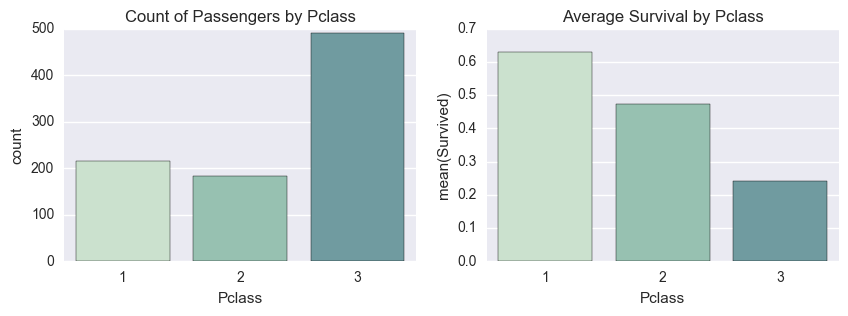

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3))
ax1.set_title('Count of Passengers by Pclass')
ax2.set_title('Average Survival by Pclass')
color = sns.cubehelix_palette(6, start=.5, rot=-.6)

avg_surv = titanic[['Pclass','Survived']].groupby('Pclass', as_index=False).mean()

sns.countplot(data=titanic, x='Pclass', ax=ax1, palette=color)
sns.barplot(data=avg_surv, x='Pclass', y='Survived', ax=ax2, palette=color)

### Exploration: Survival vs Sex and Pclass ###

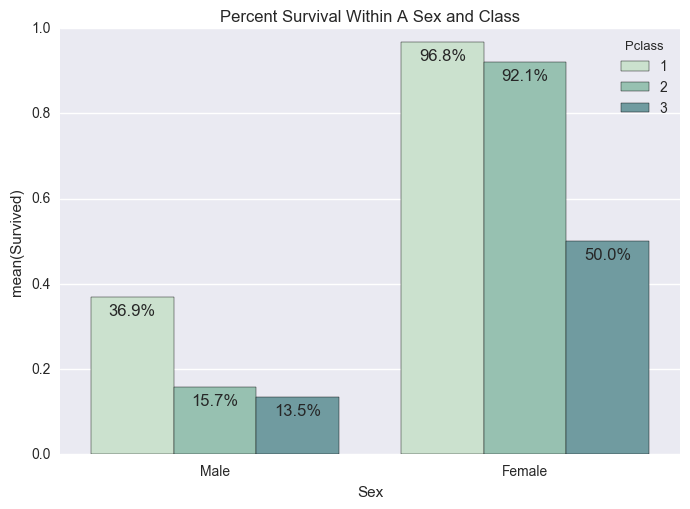

In [8]:
color = sns.cubehelix_palette(6, start=.5, rot=-.6)
ax1 = sns.barplot(data=titanic, x='Sex', y='Survived', hue='Pclass', palette=color, ci=None)
plt.title("Percent Survival Within A Sex and Class")
ax1.set_xticklabels(["Male","Female"])

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{0:.1f}%'.format(y*100), xy=(x.mean(),y-.05), ha='center', va='bottom')



There are a few takeaways from this graph:
1. Women are more likely to survive than men
2. Women in 1st and 2nd classes are very likely to survive
3. First class are more likely to survive than 2nd and 3rd classes

In [9]:
#I used this to calculate the percentage of each of the above survival groups (by Sex and Class), then
#I figured out how to display it directly on the plot...

#titanic.groupby(['Pclass','Survived','Sex'])['PassengerId'].count()
#
#Sex_Class = pd.DataFrame({'Survived_Count': titanic.groupby(['Pclass','Survived','Sex'])['PassengerId'].count()}).reset_index()
#
#classSexSurvived = {}
#for pclass in range(1,4):
#    for sex in range(0,2):
#        first_F1 = Sex_Class['Pclass']==pclass 
#        first_F = Sex_Class[first_F1]
#        first_F2 = first_F['Sex']==sex
#        first_F = first_F[first_F2].reset_index(drop=True)
#        percent1F = first_F.loc[1,'Survived_Count'] / (first_F.loc[0,'Survived_Count'] + first_F.loc[1,'Survived_Count'])
#        classSexSurvived[str(pclass)+str(sex)]=percent1F
#
#classSexSurvived

#This dictionary catalogues the percentage of each sex surving within a class. 
#The first number of the key is the Pclass, and the second number is the Sex --> '10' = First class male survival percentage




In [10]:
#I used this to see how ages were distributed among Pclasses and survivals
#
#titanic['Age'] = titanic['Age'].astype(int) 
#
#g = sns.FacetGrid(titanic, col="Survived", row="Pclass", hue='Sex', size=3)
#g.map(sns.kdeplot, "Age", shade=True)
#sns.despine(left=True, bottom=False)
#g.set(xlim=(0, 80))
#g.add_legend()
#plt.show()

Some more takeaways with these plots:
1. Likely to survive:
    * 1st class women
    * 2nd class 0-10 year olds
2. Unlikely to survive:
    * 2nd class 20-40 male

I have to be careful here though, because I don't know the numbers for each category. For example, there might have been only 5 male 2nd class passengers that didn't survive, and most of THEM were 20-40 years old. At the same time, there might have been 500 male 2nd class passengers that did survive, but most of THEM were 0-20 years old. --> The heights of these graphs only represent the percentage of their own population, not the entire Pclass, for example. I think. To be confirmed. 

### Feature: Family ###

There are two columns that describe the family of the passenger: <br>
<br>
__SibSp__ <br>
Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic <br>
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored) <br>
<br>
__Parch__ <br>
Parent:   Mother or Father of Passenger Aboard Titanic <br>
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

(0, 1)

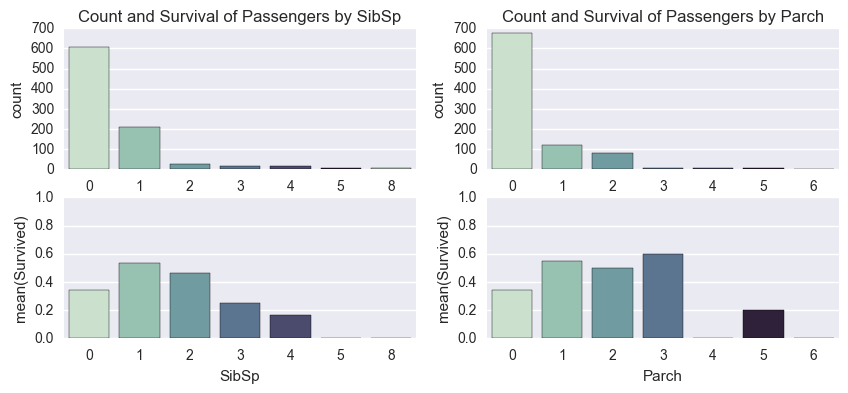

In [11]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,4))
ax1.set_title('Count and Survival of Passengers by SibSp')
ax2.set_title('Count and Survival of Passengers by Parch')
color = sns.cubehelix_palette(6, start=.5, rot=-.6)

sns.countplot(data=titanic, x='SibSp', ax=ax1, palette=color)
sns.countplot(data=titanic, x='Parch', ax=ax2, palette=color)

avg_surv = titanic[['SibSp','Survived']].groupby('SibSp', as_index=False).mean()
sns.barplot(data=avg_surv, x='SibSp', y='Survived', ax=ax3, palette=color)
ax3.set_ylim(0,1)

avg_surv = titanic[['Parch','Survived']].groupby('Parch', as_index=False).mean()
sns.barplot(data=avg_surv, x='Parch', y='Survived', ax=ax4, palette=color)
ax4.set_ylim(0,1)



(0, 1)

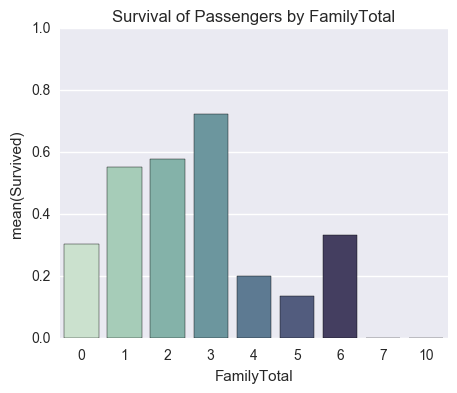

In [12]:
#Let's combine SibSp and Parch for a total family size
titanic['FamilyTotal'] = titanic['SibSp']+titanic['Parch']

fig,ax1 = plt.subplots(1,1,figsize=(5,4))
ax1.set_title('Survival of Passengers by FamilyTotal')
color = sns.cubehelix_palette(8, start=.5, rot=-.6)

avg_surv = titanic[['FamilyTotal','Survived']].groupby('FamilyTotal', as_index=False).mean()
sns.barplot(data=avg_surv, x='FamilyTotal', y='Survived', ax=ax1, palette=color)
ax1.set_ylim(0,1)

### Feature: Name Title ###

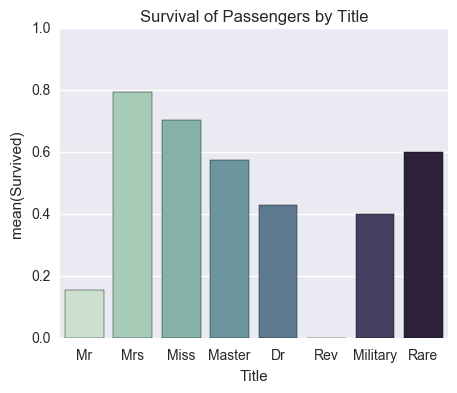

In [13]:
#Let's grab the titles of people (Mr, Mrs, etc) and see how they distribute
#print(titanic['Name'].tail(100))
def get_title(name):
    title = re.search('[A-Z][a-z]+\.', name)
    if title:
        return(title.group())
    return("")

titanic['Title'] = titanic['Name'].apply(get_title)
titanic['Title'].value_counts()

title_map = {
    'Mr.':0,
    'Mrs.':1,
    'Miss.':2,
    'Master.':3,
    'Dr.':4,
    'Rev.':5,
    'Major.':6,
    'Col.':6,
    'Mlle.':2,
    'Jonkheer.':7,
    'Lady.':7,
    'Don.':7,
    'Countess.':7,
    'Capt.':6,
    'Sir.':7,
    'Mme.':1,
    'Ms.':2
}


for title, tmap in title_map.items():
    titanic.loc[titanic['Title']==title, 'Title'] = tmap
    
titanic.head()

fig,ax1 = plt.subplots(1,1,figsize=(5,4))
ax1.set_title('Survival of Passengers by Title')
color = sns.cubehelix_palette(8, start=.5, rot=-.6)

avg_surv = titanic[['Title','Survived']].groupby('Title', as_index=False).mean()
sns.barplot(data=avg_surv, x='Title', y='Survived', ax=ax1, palette=color)
ax1.set_ylim(0,1)
ax1.set_xticklabels(["Mr","Mrs",'Miss','Master','Dr','Rev','Military','Rare'])
plt.show()

## Machine Learning Section:

In [14]:
#The features for the model
predictors = ['Pclass', 'Sex', 'Age', 'FamilyTotal', 'Title']

#Setting the algorithm (random trees)
alg = rfc(random_state=1, n_estimators=50, min_samples_split=5, min_samples_leaf=5)

#Setting up the cross validation folds
kf = cva.KFold(titanic.shape[0], n_folds=3, random_state=1)

#Running the algorithm with the kfolds
scores = cva.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=kf)

print(scores.mean())

0.822671156004
